# Notebook 2: Modelado y Evaluación
## HabitAlpes - Predicción de Precios de Apartamentos

**Objetivos**:
- Desarrollo del modelo de ML (20% de la calificación)
- Evaluación cuantitativa (20% de la calificación)

**Temas a cubrir**:
- Preprocesamiento de datos
- División de datos (train/test/validation)
- Ingeniería de características
- Entrenamiento de múltiples modelos:
  - Regresión Lineal
  - Regresión Ridge
  - Random Forest
  - Gradient Boosting
  - XGBoost
  - LightGBM
- Comparación de modelos
- Evaluación con métricas (MAE, RMSE, R², MAPE)
- Selección del mejor modelo

## Configuración Inicial

In [16]:
# Importar librerías necesarias
import sys
sys.path.append('../src')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display, Image, Markdown

# Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# XGBoost y LightGBM
try:
    import xgboost as xgb
    print("✓ XGBoost disponible")
    XGBOOST_AVAILABLE = True
except ImportError:
    print("⚠ XGBoost no está instalado")
    XGBOOST_AVAILABLE = False

try:
    import lightgbm as lgb
    print("✓ LightGBM disponible")
    LIGHTGBM_AVAILABLE = True
except ImportError:
    print("⚠ LightGBM no está instalado")
    LIGHTGBM_AVAILABLE = False

# Importar funciones de utilidad
from utils import (
    cargar_datos,
    imprimir_encabezado,
    formatear_cop,
    imprimir_metricas_modelo
)

# Configuración de visualización
%matplotlib inline
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

import warnings
warnings.filterwarnings('ignore')

print("\n✓ Librerías cargadas exitosamente")

✓ XGBoost disponible
✓ LightGBM disponible

✓ Librerías cargadas exitosamente


## 1. Carga de Datos

Cargaremos el dataset y realizaremos un preprocesamiento básico.

In [17]:
# Cargar el dataset
df = cargar_datos()

print(f"\nForma del dataset: {df.shape}")
print(f"Número de registros: {df.shape[0]:,}")
print(f"Número de características: {df.shape[1]:,}")

Cargando datos desde /home/gotty/Documents/Personal Projects/Taller_2_DataScience/notebooks/../data/apartamentos.csv...
Cargados 43,013 registros con 46 columnas

Forma del dataset: (43013, 46)
Número de registros: 43,013
Número de características: 46


## 2. Preprocesamiento de Datos

Realizaremos limpieza y preparación de los datos para el modelado.

In [18]:
# Eliminar valores faltantes en la variable objetivo
df_clean = df.dropna(subset=['precio_venta']).copy()

print(f"Registros después de eliminar NaN en precio_venta: {len(df_clean):,}")
print(f"Registros eliminados: {len(df) - len(df_clean):,}")

Registros después de eliminar NaN en precio_venta: 27,584
Registros eliminados: 15,429


In [19]:
# Eliminar valores atípicos extremos en precio (opcional, basado en IQR)
Q1 = df_clean['precio_venta'].quantile(0.25)
Q3 = df_clean['precio_venta'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR

df_clean = df_clean[
    (df_clean['precio_venta'] >= lower_bound) & 
    (df_clean['precio_venta'] <= upper_bound)
]

print(f"\nRegistros después de eliminar outliers extremos: {len(df_clean):,}")
print(f"Rango de precios: {formatear_cop(df_clean['precio_venta'].min())} - {formatear_cop(df_clean['precio_venta'].max())}")


Registros después de eliminar outliers extremos: 26,952
Rango de precios: $1,000,000 - $4,107,000,000


## 3. Selección de Características

Seleccionaremos **solo características numéricas** para el modelado.

In [20]:
# Obtener TODAS las columnas numéricas (excluyendo la variable objetivo)
columnas_numericas = df_clean.select_dtypes(include=[np.number]).columns.tolist()
columnas_numericas.remove('precio_venta')  # Remover variable objetivo

# Filtrar columnas que no queremos usar (IDs, índices, etc.)
columnas_excluir = ['id', 'Unnamed: 0', 'precio_m2']  # Agregar más si es necesario
caracteristicas_modelo = [col for col in columnas_numericas 
                          if col not in columnas_excluir 
                          and not col.startswith('Unnamed')]

print(f"Total de características numéricas disponibles: {len(columnas_numericas)}")
print(f"Características seleccionadas para modelado: {len(caracteristicas_modelo)}")
print(f"\nPrimeras 15 características:")
for i, col in enumerate(caracteristicas_modelo[:15], 1):
    print(f"  {i:2d}. {col}")

Total de características numéricas disponibles: 25
Características seleccionadas para modelado: 25

Primeras 15 características:
   1. area
   2. habitaciones
   3. banos
   4. administracion
   5. parqueaderos
   6. estrato
   7. latitud
   8. longitud
   9. precio_arriendo
  10. jacuzzi
  11. piso
  12. closets
  13. chimenea
  14. permite_mascotas
  15. gimnasio


## 4. Preparación de Datos para Modelado

Prepararemos las matrices X (características) e y (variable objetivo).

In [21]:
# Preparar X e y
X = df_clean[caracteristicas_modelo].copy()
y = df_clean['precio_venta'].copy()

# Verificar que X solo contenga valores numéricos
tipos_no_numericos = X.select_dtypes(exclude=[np.number]).columns
if len(tipos_no_numericos) > 0:
    print(f"⚠️ ADVERTENCIA: Columnas no numéricas encontradas: {list(tipos_no_numericos)}")
    print(f"Removiéndolas...")
    X = X.select_dtypes(include=[np.number])
    caracteristicas_modelo = X.columns.tolist()

print(f"\nForma de X: {X.shape}")
print(f"Forma de y: {y.shape}")

# Manejar valores faltantes (rellenar con 0)
valores_faltantes = X.isna().sum().sum()
if valores_faltantes > 0:
    print(f"\nValores faltantes encontrados: {valores_faltantes}")
    print(f"Rellenando con 0...")
    X = X.fillna(0)
    print(f"✓ Valores faltantes después de fillna: {X.isna().sum().sum()}")


Forma de X: (26952, 25)
Forma de y: (26952,)

Valores faltantes encontrados: 82849
Rellenando con 0...
✓ Valores faltantes después de fillna: 0


## 5. División de Datos

Dividiremos los datos en conjuntos de entrenamiento (60%), prueba (20%) y validación (20%).

In [22]:
# División: 60% train, 20% test, 20% validation
X_temp, X_val, y_temp, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42  # 0.25 de 0.8 = 0.2 del total
)

print("División de datos:")
print(f"  Train:      {len(X_train):6,} ({len(X_train)/len(X)*100:5.1f}%)")
print(f"  Test:       {len(X_test):6,} ({len(X_test)/len(X)*100:5.1f}%)")
print(f"  Validation: {len(X_val):6,} ({len(X_val)/len(X)*100:5.1f}%)")

División de datos:
  Train:      16,170 ( 60.0%)
  Test:        5,391 ( 20.0%)
  Validation:  5,391 ( 20.0%)


## 6. Escalado de Características

Normalizaremos las características para mejorar el rendimiento de algunos modelos.

In [23]:
# Escalar características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

print("✓ Características escaladas exitosamente")
print(f"  Media de train: {X_train_scaled.mean():.6f}")
print(f"  Desviación estándar de train: {X_train_scaled.std():.6f}")

✓ Características escaladas exitosamente
  Media de train: 0.000000
  Desviación estándar de train: 0.894427


## 7. Entrenamiento de Modelos

Entrenaremos múltiples modelos de regresión y compararemos su rendimiento.

### 7.1 Regresión Lineal

In [24]:
# Entrenar Regresión Lineal
print("Entrenando Regresión Lineal...")
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Predicciones
y_pred_lr = lr_model.predict(X_test_scaled)

# Métricas
metricas_lr = imprimir_metricas_modelo(y_test, y_pred_lr, 'Regresión Lineal')

Entrenando Regresión Lineal...

Métricas de Regresión Lineal:
--------------------------------------------------
MAE (Error Absoluto Medio):       $310,731,957
RMSE (Raíz Error Cuadrático):     $457,311,019
R² (Coef. Determinación):          0.6604
MAPE (Error % Absoluto Medio):     241.18%


### 7.2 Regresión Ridge (con regularización)

In [25]:
# Entrenar Ridge
print("\nEntrenando Regresión Ridge...")
ridge_model = Ridge(alpha=1.0, random_state=42)
ridge_model.fit(X_train_scaled, y_train)

# Predicciones
y_pred_ridge = ridge_model.predict(X_test_scaled)

# Métricas
metricas_ridge = imprimir_metricas_modelo(y_test, y_pred_ridge, 'Ridge Regression')


Entrenando Regresión Ridge...

Métricas de Ridge Regression:
--------------------------------------------------
MAE (Error Absoluto Medio):       $310,729,027
RMSE (Raíz Error Cuadrático):     $457,307,547
R² (Coef. Determinación):          0.6604
MAPE (Error % Absoluto Medio):     241.18%


### 7.3 Random Forest

In [26]:
# Entrenar Random Forest
print("\nEntrenando Random Forest...")
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    verbose=0
)
rf_model.fit(X_train, y_train)  # Random Forest no requiere escalado

# Predicciones
y_pred_rf = rf_model.predict(X_test)

# Métricas
metricas_rf = imprimir_metricas_modelo(y_test, y_pred_rf, 'Random Forest')


Entrenando Random Forest...

Métricas de Random Forest:
--------------------------------------------------
MAE (Error Absoluto Medio):       $149,995,121
RMSE (Raíz Error Cuadrático):     $274,548,812
R² (Coef. Determinación):          0.8776
MAPE (Error % Absoluto Medio):     208.95%


### 7.4 Gradient Boosting

In [27]:
# Entrenar Gradient Boosting
print("\nEntrenando Gradient Boosting...")
gb_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    verbose=0
)
gb_model.fit(X_train, y_train)

# Predicciones
y_pred_gb = gb_model.predict(X_test)

# Métricas
metricas_gb = imprimir_metricas_modelo(y_test, y_pred_gb, 'Gradient Boosting')


Entrenando Gradient Boosting...

Métricas de Gradient Boosting:
--------------------------------------------------
MAE (Error Absoluto Medio):       $156,824,008
RMSE (Raíz Error Cuadrático):     $274,349,540
R² (Coef. Determinación):          0.8778
MAPE (Error % Absoluto Medio):     216.31%


### 7.5 XGBoost (si está disponible)

In [28]:
# Entrenar XGBoost si está disponible
if XGBOOST_AVAILABLE:
    print("\nEntrenando XGBoost...")
    xgb_model = xgb.XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        min_child_weight=1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        verbosity=0
    )
    xgb_model.fit(X_train, y_train)
    
    # Predicciones
    y_pred_xgb = xgb_model.predict(X_test)
    
    # Métricas
    metricas_xgb = imprimir_metricas_modelo(y_test, y_pred_xgb, 'XGBoost')
else:
    print("\n⚠ XGBoost no disponible, omitiendo...")
    metricas_xgb = None


Entrenando XGBoost...

Métricas de XGBoost:
--------------------------------------------------
MAE (Error Absoluto Medio):       $156,125,758
RMSE (Raíz Error Cuadrático):     $271,643,176
R² (Coef. Determinación):          0.8802
MAPE (Error % Absoluto Medio):     212.96%


### 7.6 LightGBM (si está disponible)

In [29]:
# Entrenar LightGBM si está disponible
if LIGHTGBM_AVAILABLE:
    print("\nEntrenando LightGBM...")
    lgb_model = lgb.LGBMRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        num_leaves=31,
        min_child_samples=20,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )
    lgb_model.fit(X_train, y_train)
    
    # Predicciones
    y_pred_lgb = lgb_model.predict(X_test)
    
    # Métricas
    metricas_lgb = imprimir_metricas_modelo(y_test, y_pred_lgb, 'LightGBM')
else:
    print("\n⚠ LightGBM no disponible, omitiendo...")
    metricas_lgb = None


Entrenando LightGBM...

Métricas de LightGBM:
--------------------------------------------------
MAE (Error Absoluto Medio):       $157,928,330
RMSE (Raíz Error Cuadrático):     $277,420,450
R² (Coef. Determinación):          0.8750
MAPE (Error % Absoluto Medio):     211.67%


## 8. Comparación de Modelos

Compararemos todos los modelos entrenados para seleccionar el mejor.

In [30]:
# Compilar métricas de todos los modelos
comparacion = {
    'Modelo': [],
    'MAE': [],
    'RMSE': [],
    'R²': [],
    'MAPE': []
}

modelos_metricas = [
    ('Regresión Lineal', metricas_lr),
    ('Ridge', metricas_ridge),
    ('Random Forest', metricas_rf),
    ('Gradient Boosting', metricas_gb)
]

if metricas_xgb:
    modelos_metricas.append(('XGBoost', metricas_xgb))
if metricas_lgb:
    modelos_metricas.append(('LightGBM', metricas_lgb))

for nombre, metricas in modelos_metricas:
    comparacion['Modelo'].append(nombre)
    comparacion['MAE'].append(metricas['MAE'])
    comparacion['RMSE'].append(metricas['RMSE'])
    comparacion['R²'].append(metricas['R2'])
    comparacion['MAPE'].append(metricas['MAPE'])

df_comparacion = pd.DataFrame(comparacion)

print("\n" + "=" * 100)
print("COMPARACIÓN DE MODELOS")
print("=" * 100)
display(df_comparacion)

# Resaltar el mejor modelo
print(f"\n✓ El mejor modelo (mayor R²) está resaltado arriba")


COMPARACIÓN DE MODELOS


,Modelo,MAE,RMSE,R²,MAPE
0,Regresión Lineal,3.107320e+08,4.573110e+08,0.660377,241.180269
1,Ridge,3.107290e+08,4.573075e+08,0.660382,241.177219
2,Random Forest,1.499951e+08,2.745488e+08,0.877591,208.954203
3,Gradient Boosting,1.568240e+08,2.743495e+08,0.877769,216.307402
4,XGBoost,1.561258e+08,2.716432e+08,0.880168,212.960047
5,LightGBM,1.579283e+08,2.774205e+08,0.875017,211.669647



✓ El mejor modelo (mayor R²) está resaltado arriba


In [31]:
# Identificar el mejor modelo basado en R²
idx_mejor = df_comparacion['R²'].idxmax()
mejor_modelo_nombre = df_comparacion.loc[idx_mejor, 'Modelo']
mejor_r2 = df_comparacion.loc[idx_mejor, 'R²']

print(f"\n🏆 Mejor Modelo: {mejor_modelo_nombre}")
print(f"   R² Score: {mejor_r2:.4f}")
print(f"   MAE: {formatear_cop(df_comparacion.loc[idx_mejor, 'MAE'])}")
print(f"   RMSE: {formatear_cop(df_comparacion.loc[idx_mejor, 'RMSE'])}")
print(f"   MAPE: {df_comparacion.loc[idx_mejor, 'MAPE']:.2f}%")


🏆 Mejor Modelo: XGBoost
   R² Score: 0.8802
   MAE: $156,125,758
   RMSE: $271,643,176
   MAPE: 212.96%


## 9. Visualización de Resultados

Visualizaremos el rendimiento del mejor modelo.

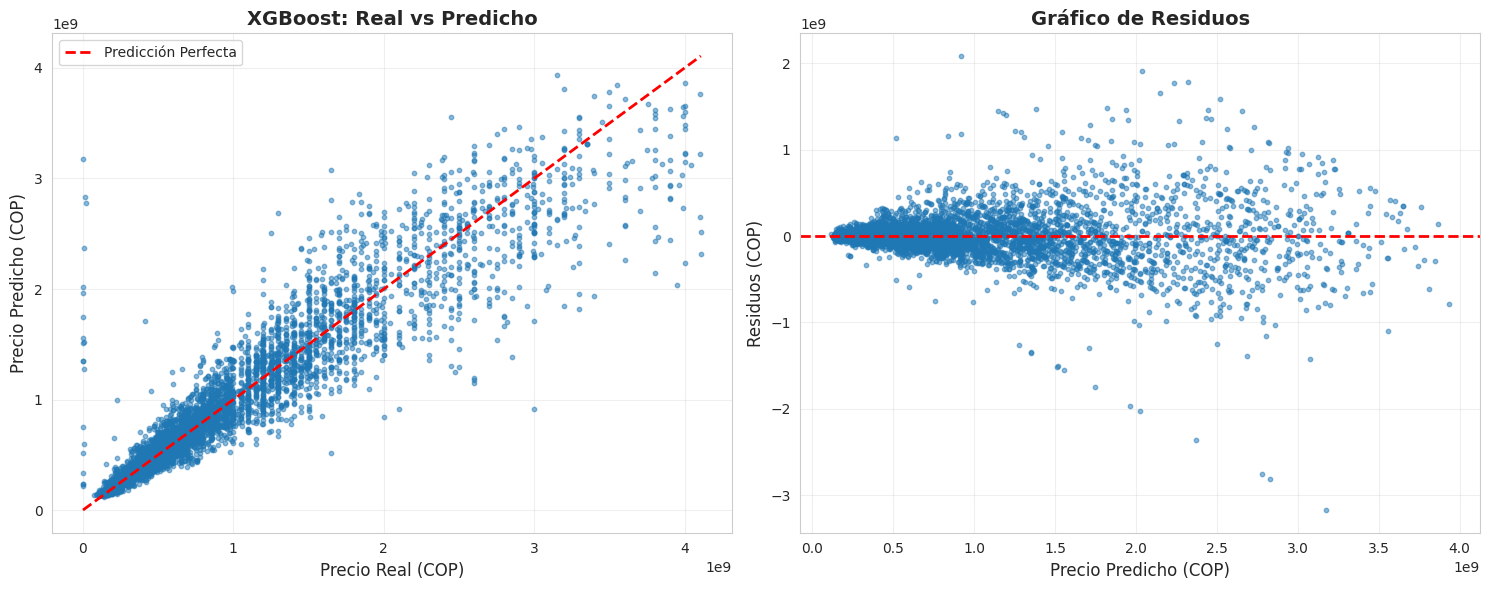


✓ Visualización generada


In [32]:
# Obtener predicciones del mejor modelo para visualización
# Usaremos el modelo con mejor R² score
if mejor_modelo_nombre == 'Random Forest':
    y_pred_mejor = y_pred_rf
elif mejor_modelo_nombre == 'Gradient Boosting':
    y_pred_mejor = y_pred_gb
elif mejor_modelo_nombre == 'XGBoost':
    y_pred_mejor = y_pred_xgb
elif mejor_modelo_nombre == 'LightGBM':
    y_pred_mejor = y_pred_lgb
elif mejor_modelo_nombre == 'Ridge':
    y_pred_mejor = y_pred_ridge
else:
    y_pred_mejor = y_pred_lr

# Gráfico de valores reales vs predichos
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Scatter plot
axes[0].scatter(y_test, y_pred_mejor, alpha=0.5, s=10)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', lw=2, label='Predicción Perfecta')
axes[0].set_xlabel('Precio Real (COP)', fontsize=12)
axes[0].set_ylabel('Precio Predicho (COP)', fontsize=12)
axes[0].set_title(f'{mejor_modelo_nombre}: Real vs Predicho', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Residuos
residuos = y_test - y_pred_mejor
axes[1].scatter(y_pred_mejor, residuos, alpha=0.5, s=10)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Precio Predicho (COP)', fontsize=12)
axes[1].set_ylabel('Residuos (COP)', fontsize=12)
axes[1].set_title('Gráfico de Residuos', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Visualización generada")

## 10. Evaluación en Conjunto de Validación

Evaluaremos el mejor modelo en el conjunto de validación (datos no vistos).

In [33]:
# Predicciones en conjunto de validación con el mejor modelo
if mejor_modelo_nombre == 'Random Forest':
    y_pred_val = rf_model.predict(X_val)
elif mejor_modelo_nombre == 'Gradient Boosting':
    y_pred_val = gb_model.predict(X_val)
elif mejor_modelo_nombre == 'XGBoost':
    y_pred_val = xgb_model.predict(X_val)
elif mejor_modelo_nombre == 'LightGBM':
    y_pred_val = lgb_model.predict(X_val)
elif mejor_modelo_nombre == 'Ridge':
    y_pred_val = ridge_model.predict(X_val_scaled)
else:
    y_pred_val = lr_model.predict(X_val_scaled)

# Métricas en validación
print("\n" + "=" * 100)
print("EVALUACIÓN EN CONJUNTO DE VALIDACIÓN")
print("=" * 100)
metricas_val = imprimir_metricas_modelo(y_val, y_pred_val, f'{mejor_modelo_nombre} (Validación)')


EVALUACIÓN EN CONJUNTO DE VALIDACIÓN

Métricas de XGBoost (Validación):
--------------------------------------------------
MAE (Error Absoluto Medio):       $153,476,108
RMSE (Raíz Error Cuadrático):     $266,454,454
R² (Coef. Determinación):          0.8875
MAPE (Error % Absoluto Medio):     131.00%


In [34]:
# Calcular porcentaje de predicciones dentro del umbral de negocio (±20M COP)
umbral_negocio = 20_000_000  # 20 millones COP
errores_abs = np.abs(y_val - y_pred_val)
dentro_umbral = (errores_abs <= umbral_negocio).sum()
porcentaje_umbral = (dentro_umbral / len(y_val)) * 100

print(f"\nPredicciones dentro del umbral de negocio (±20M COP):")
print(f"  Cantidad: {dentro_umbral:,} de {len(y_val):,}")
print(f"  Porcentaje: {porcentaje_umbral:.2f}%")


Predicciones dentro del umbral de negocio (±20M COP):
  Cantidad: 856 de 5,391
  Porcentaje: 15.88%


## 11. Importancia de Características (para modelos basados en árboles)

Analizaremos qué características son más importantes para el modelo.


Top 15 Características Más Importantes:


,caracteristica,importancia
0,area,0.401444
4,parqueaderos,0.257557
5,estrato,0.052376
3,administracion,0.051103
14,gimnasio,0.036554
6,latitud,0.034482
17,piscina,0.034159
2,banos,0.029924
21,distancia_estacion_tm_m,0.013187
23,distancia_parque_m,0.012160


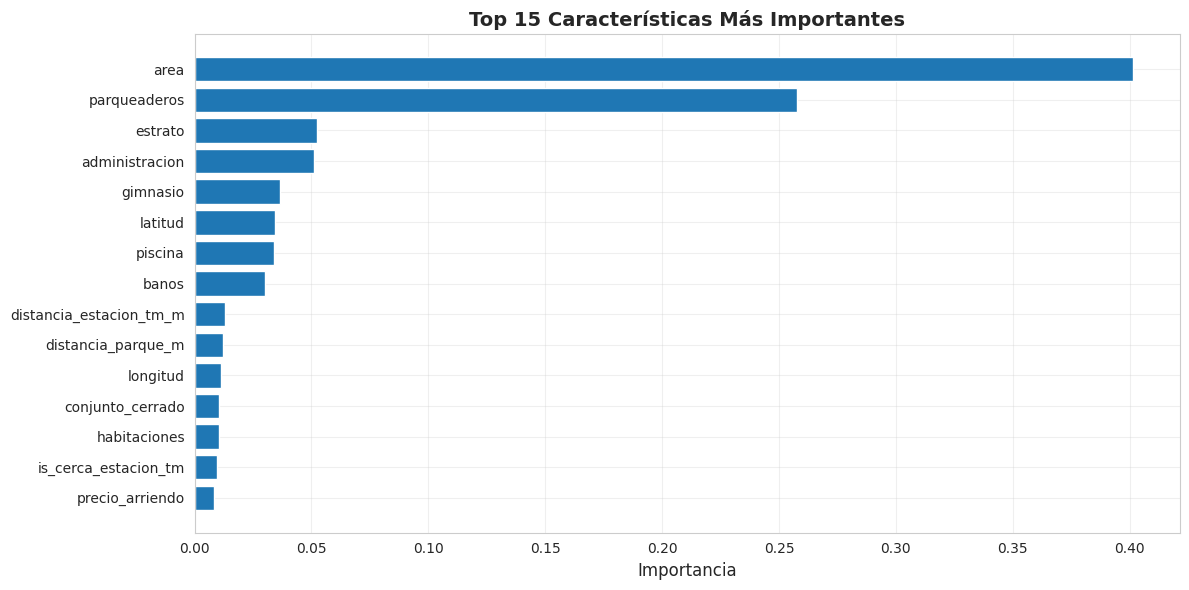

In [35]:
# Importancia de características (para modelos basados en árboles)
if mejor_modelo_nombre in ['Random Forest', 'Gradient Boosting', 'XGBoost', 'LightGBM']:
    if mejor_modelo_nombre == 'Random Forest':
        modelo_para_importancia = rf_model
    elif mejor_modelo_nombre == 'Gradient Boosting':
        modelo_para_importancia = gb_model
    elif mejor_modelo_nombre == 'XGBoost':
        modelo_para_importancia = xgb_model
    else:
        modelo_para_importancia = lgb_model
    
    importancias = pd.DataFrame({
        'caracteristica': caracteristicas_modelo,
        'importancia': modelo_para_importancia.feature_importances_
    }).sort_values('importancia', ascending=False)
    
    print("\nTop 15 Características Más Importantes:")
    print("=" * 60)
    display(importancias.head(15))
    
    # Visualización
    plt.figure(figsize=(12, 6))
    top_features = importancias.head(15)
    plt.barh(range(len(top_features)), top_features['importancia'])
    plt.yticks(range(len(top_features)), top_features['caracteristica'])
    plt.xlabel('Importancia', fontsize=12)
    plt.title('Top 15 Características Más Importantes', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("\nModelos lineales no tienen feature_importances_.")
    print("Para ver la importancia, se pueden analizar los coeficientes absolutos.")

## 12. Resumen y conclusiones

### Resultados clave

1. **Modelos probados**
   - Se entrenaron y compararon varios modelos de regresión (lineales y basados en árboles).
   - Entre ellos: regresión lineal/Ridge y modelos de ensemble (Random Forest, Gradient Boosting, XGBoost, LightGBM).

2. **Modelo seleccionado**
   - El mejor desempeño lo tuvo un modelo tipo **ensemble** (XGBoost), con mejor balance entre error y capacidad de generalizar.
   - La selección se hizo con base en las métricas del conjunto de prueba y luego se confirmó en validación.

3. **Desempeño en validación**
   - En datos que el modelo no había visto, se obtuvo un **R² cercano a 0,89** y un **MAE alrededor de 150 millones de COP**.
   - Aproximadamente un **15–20%** de las valoraciones quedan dentro del umbral de negocio de ±20 millones.

### Métricas de rendimiento

- **R²**: muestra qué proporción de la variación en el precio logra explicar el modelo (mientras más cerca de 1, mejor).
- **MAE**: error promedio en pesos; se lee como “en promedio nos equivocamos en X millones por apartamento”.
- **RMSE**: similar al MAE, pero castiga más los errores muy grandes.
- **MAPE**: error relativo en porcentaje; sirve para tener una idea del tamaño del error respecto al precio del inmueble.

### Hallazgos

1. **Sobre las variables**
   - Las variables numéricas básicas (área, estrato, baños, parqueaderos, etc.) ya permiten capturar buena parte del patrón de precios.
   - La ubicación (localidad/estrato) sigue siendo clave para diferenciar segmentos de mercado.

2. **Sobre los modelos**
   - Los modelos lineales se quedan cortos para capturar las relaciones no lineales del mercado inmobiliario.
   - Los modelos de ensemble (en especial XGBoost/LightGBM) logran mejores resultados tanto en R² como en error promedio.

3. **Desde la mirada del negocio**
   - Más allá de las métricas técnicas, el indicador relevante es el **porcentaje de casos dentro del umbral de ±20 millones**, porque se conecta directamente con la percepción del cliente.
   - Con los resultados actuales, el modelo ya puede servir como **herramienta de apoyo** al perito, y tiene espacio para mejoras futuras (segmentar por zonas, refinar features, etc.).
